In [3]:
import os
import random
import torch
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import lovely_tensors as lt
lt.monkey_patch()

from csng.utils.data import crop
from csng.data import get_dataloaders, get_sample_data
from csng.models.readins import MEIReadIn
from csng.utils.mix import seed_all, update_config_paths, update_config_keys_to_value, plot_comparison
from csng.models.utils.gan import init_decoder as init_gan_decoder
from csng.models.utils.cnn import init_decoder as init_cnn_decoder
from csng.models.utils.gan import train
from csng.utils.comparison import eval_decoder
from csng.losses import get_metrics
from csng.brainreader_mouse.encoder import get_encoder as get_encoder_brainreader
from csng.mouse_v1.encoder import get_encoder as get_encoder_sensorium_mouse_v1
from csng.cat_v1.encoder import get_encoder as get_encoder_cat_v1
from csng.brainreader_mouse.data import get_brainreader_mouse_dataloaders

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, PoissonRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### set paths
DATA_PATH = os.environ["DATA_PATH"]
DATA_PATH_CAT_V1 = os.path.join(DATA_PATH, "cat_V1_spiking_model", "50K_single_trial_dataset")
DATA_PATH_MOUSE_V1 = os.path.join(DATA_PATH, "mouse_v1_sensorium22")
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, "brainreader")
print(f"{DATA_PATH=}\n{DATA_PATH_CAT_V1=}\n{DATA_PATH_MOUSE_V1=}\n{DATA_PATH_BRAINREADER=}")

!nvidia-smi

DATA_PATH='/media/jan/ext_ssd/csng_data'
DATA_PATH_CAT_V1='/media/jan/ext_ssd/csng_data/cat_V1_spiking_model/50K_single_trial_dataset'
DATA_PATH_MOUSE_V1='/media/jan/ext_ssd/csng_data/mouse_v1_sensorium22'
DATA_PATH_BRAINREADER='/media/jan/ext_ssd/csng_data/brainreader'
Mon Jul 28 19:38:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.169                Driver Version: 570.169        CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   0000000

## Data

In [ ]:
# --- 1. Synthetic Data Generation ---
# This part simulates the experiment. In a real scenario, you would load your own data here.
from scipy.signal import convolve2d


def create_gabor(size, lambda_, theta, sigma, phase):
    """Creates a Gabor patch, a common model for V1 simple cell RFs."""
    x, y = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)
    gb = np.exp(-0.5 * (x_theta**2 / sigma**2 + y_theta**2 / sigma**2)) * np.cos(2 * np.pi * x_theta / lambda_ + phase)
    return gb

# --- Parameters for our simulated experiment ---
image_size = 32       # The height and width of our stimulus images
n_samples = 5000      # Number of stimulus-response pairs
noise_level = 1.5     # How noisy the neuron's responses are

# Create the "ground truth" receptive field we want to recover
true_rf = create_gabor(size=image_size, lambda_=0.5, theta=np.pi/4, sigma=0.2, phase=0)
true_bias = 2.0  # Neuron's baseline firing rate

# Generate random pixel stimuli (you could use natural image patches here too)
# For this example, we use correlated noise to show why regression is better than STA
np.random.seed(42)
stimuli_raw = np.random.randn(n_samples, image_size, image_size)
# Add correlations by smoothing the noise
for i in range(n_samples):
    stimuli_raw[i] = convolve2d(stimuli_raw[i], np.ones((3,3))/9, mode='same', boundary='wrap')

In [5]:
# --- Simulate the Neuron's Response ---
# Flatten the stimuli and the true RF for dot product calculation
stimuli_flat = stimuli_raw.reshape(n_samples, -1)
true_rf_flat = true_rf.flatten()

# Calculate the "perfect" response using the linear model
perfect_responses = np.dot(stimuli_flat, true_rf_flat) + true_bias

# Add Gaussian noise to simulate biological variability
noisy_responses = perfect_responses + np.random.normal(0, noise_level, n_samples)

# For the GLM model, we'll create positive spike counts (e.g., Poisson-like)
# The exp() function is a common "link function" for Poisson models
poisson_rate = np.exp(0.4 * (perfect_responses - np.mean(perfect_responses))) # Scale and exponentiate
poisson_responses = np.random.poisson(poisson_rate)

In [6]:
# --- 2. Data Preprocessing & Splitting ---
# It's good practice to split data into training and testing sets
X_train, X_test, y_train_lin, y_test_lin = train_test_split(
    stimuli_flat, noisy_responses, test_size=0.2, random_state=42
)
_, _, y_train_poi, y_test_poi = train_test_split(
    stimuli_flat, poisson_responses, test_size=0.2, random_state=42
)

# Standardizing the stimuli can help the optimization algorithm converge faster
# Although for simple Linear Regression it's not strictly necessary, it's good practice.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
### setup config
cfg = {
    "device": os.environ["DEVICE"],
    "seed": 0,
    "save_path": os.path.join(DATA_PATH, "models", "encoder_b6.pt"),
    "data": dict(),
}

### brainreader mouse data
cfg["data"]["brainreader_mouse"] = {
    "device": cfg["device"],
    "mixing_strategy": "sequential",
    "max_batches": None,
    "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
    "batch_size": 128,
    "sessions": [6],
    "resize_stim_to": (36, 64),
    "normalize_stim": True,
    "normalize_resp": False,
    "div_resp_by_std": True,
    "clamp_neg_resp": False,
    "additional_keys": None,
    "avg_test_resp": True,
    "train_datapoint_idxs_to_use": None,
    # "train_datapoint_idxs_to_use": np.random.default_rng(seed=cfg["seed"]).choice(4500, size=2000, replace=False),
}

In [6]:
# Collect responses
dls = get_brainreader_mouse_dataloaders(config=cfg["data"]["brainreader_mouse"])["brainreader_mouse"]

stim_all, resp_all = [], []
for dp in dls["train"]:
    assert len(dp) == 1

    # Save
    stim_all.append(dp[0]["stim"].cpu().detach())
    resp_all.append(dp[0]["resp"].cpu().detach())

# Save responses to file
stim_all = torch.cat(stim_all, dim=0)  # (N, C, H, W)
resp_all = torch.cat(resp_all, dim=0)  # (N, n_neurons)
print(f"Collected {resp_all.shape[0]} responses with shape {resp_all.shape}.")
torch.save({"stim_all": stim_all, "resp_all": resp_all, "config": cfg}, "b6_data_for_linear_receptive_field_fitting.pt")

Collected 4500 responses with shape torch.Size([4500, 8587]).


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [8]:
# Model definition
class LinearizedEncoder(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(input_features, output_features)

    def forward(self, x):
        # x shape: (B, C, H, W)
        x_flat = self.flatten(x) # shape: (B, C*H*W)
        return self.linear(x_flat) # shape: (B, output_features)

In [18]:
# Hyperparameters
cfg["linear"] = {
    "data_path": "b6_data_for_linear_receptive_field_fitting.pt",
    "batch_size": 256,
    "learning_rate": 3e-3,
    "weight_decay": 1e-4,
    "epochs": 10,
    "val_split": 0.1,
}

In [19]:
# Data
seed_all(cfg["seed"])
data = torch.load(cfg["linear"]["data_path"], map_location="cpu")
X, y = data["stim_all"], data["resp_all"]

print(f"Stimulus shape (X): {X.shape}")
print(f"Target response shape (y): {y.shape}")

# Create a dataset and dataloaders
dataset = TensorDataset(X, y)

# Split into training and validation sets
val_size = int(len(dataset) * cfg["linear"]["val_split"])
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=cfg["linear"]["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=cfg["linear"]["batch_size"], shuffle=False)
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Stimulus shape (X): torch.Size([4500, 1, 36, 64])
Target response shape (y): torch.Size([4500, 8587])
Training set size: 4050
Validation set size: 450


In [20]:
# Model
_, C, H, W = X.shape
_, n_neurons = y.shape
input_features = C * H * W

model = LinearizedEncoder(input_features, n_neurons).to(cfg["device"])
print(f"\nInitialized Linear model with {input_features} input features and {n_neurons} output features.")

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=cfg["linear"]["learning_rate"], weight_decay=cfg["linear"]["weight_decay"])


Initialized Linear model with 2304 input features and 8587 output features.


In [21]:
# --- Step 4: Training and Validation Loop ---
print("\nStarting training...")
history = {"train_loss": [], "val_loss": [], "val_r2": []}
for epoch in range(cfg["linear"]["epochs"]):
    # Training phase
    model.train()
    total_train_loss = 0
    for stim_batch, resp_batch in train_loader:
        stim_batch, resp_batch = stim_batch.to(cfg["device"]), resp_batch.to(cfg["device"])

        optimizer.zero_grad()
        predictions = model(stim_batch)
        loss = criterion(predictions, resp_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)

    # Validation phase
    model.eval()
    total_val_loss = 0
    all_targets = []
    all_preds = []
    with torch.no_grad():
        for stim_batch, resp_batch in val_loader:
            stim_batch, resp_batch = stim_batch.to(cfg["device"]), resp_batch.to(cfg["device"])
            predictions = model(stim_batch)
            loss = criterion(predictions, resp_batch)
            total_val_loss += loss.item()
            
            all_targets.append(resp_batch.cpu().numpy())
            all_preds.append(predictions.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    history["val_loss"].append(avg_val_loss)

    # Calculate R-squared score for the entire validation set
    all_targets = np.concatenate(all_targets, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    # Calculate R2 per neuron and average. This is a robust metric.
    r2 = r2_score(all_targets, all_preds, multioutput='variance_weighted')
    history["val_r2"].append(r2)

    print(f"Epoch {epoch+1}/{cfg['linear']['epochs']} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | Val R²: {r2:.4f}")


Starting training...
Epoch 1/10 | Train Loss: 4.692912 | Val Loss: 3.177482 | Val R²: -2.1131
Epoch 2/10 | Train Loss: 1.797295 | Val Loss: 1.494604 | Val R²: -0.4716
Epoch 3/10 | Train Loss: 1.237326 | Val Loss: 1.214700 | Val R²: -0.1991
Epoch 4/10 | Train Loss: 1.095898 | Val Loss: 1.152525 | Val R²: -0.1379
Epoch 5/10 | Train Loss: 1.042427 | Val Loss: 1.124442 | Val R²: -0.1102
Epoch 6/10 | Train Loss: 1.011619 | Val Loss: 1.114581 | Val R²: -0.1005
Epoch 7/10 | Train Loss: 0.991566 | Val Loss: 1.112502 | Val R²: -0.0984
Epoch 8/10 | Train Loss: 0.972542 | Val Loss: 1.103510 | Val R²: -0.0895
Epoch 9/10 | Train Loss: 0.958291 | Val Loss: 1.105577 | Val R²: -0.0915
Epoch 10/10 | Train Loss: 0.943875 | Val Loss: 1.104460 | Val R²: -0.0903



Training complete.


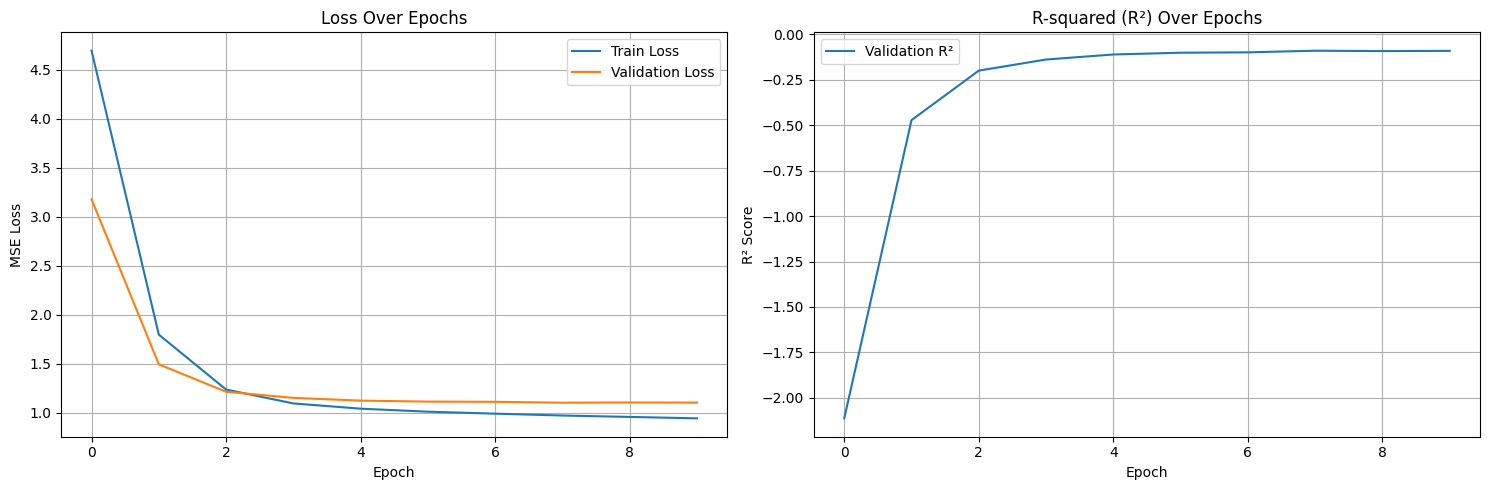

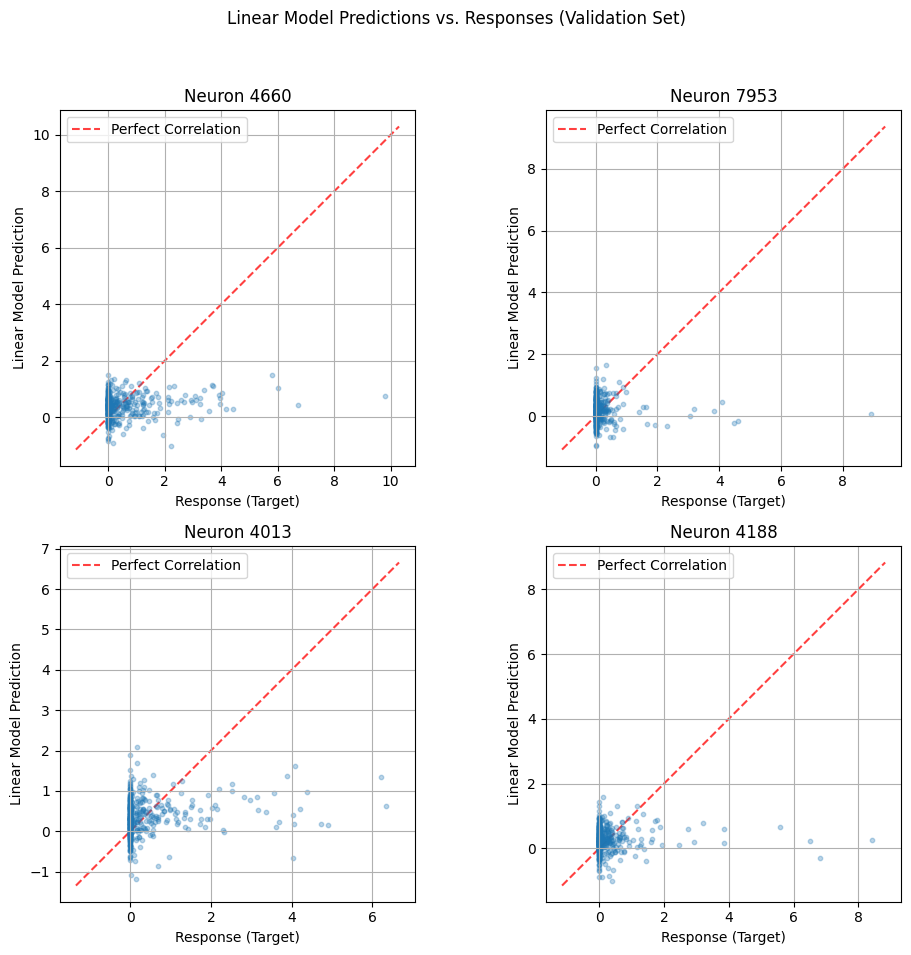

In [23]:
# --- Step 5: Final Evaluation and Visualization ---
print("\nTraining complete.")

# Plotting training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history["train_loss"], label="Train Loss")
ax1.plot(history["val_loss"], label="Validation Loss")
ax1.set_title("Loss Over Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE Loss")
ax1.legend()
ax1.grid(True)

ax2.plot(history["val_r2"], label="Validation R²")
ax2.set_title("R-squared (R²) Over Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("R² Score")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Visualize predictions vs. actuals for a few example neurons
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
for i, neuron_idx in enumerate(np.random.choice(n_neurons, 4, replace=False)):
    ax = axes[i]
    ax.scatter(all_targets[:, neuron_idx], all_preds[:, neuron_idx], alpha=0.3, s=10)
    # Plot a perfect correlation line
    lims = [
        min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1]),
    ]
    ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label="Perfect Correlation")
    ax.set_xlabel("Response (Target)")
    ax.set_ylabel("Linear Model Prediction")
    ax.set_title(f"Neuron {neuron_idx}")
    ax.legend()
    ax.grid(True)
    ax.set_aspect('equal', adjustable='box')

fig.suptitle("Linear Model Predictions vs. Responses (Validation Set)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [24]:
# Get the estimated receptive fields
rf_weights = model.linear.weight.cpu().detach().numpy()  # Shape: (n_neurons, C*H*W)
rf_weights = rf_weights.reshape(n_neurons, C, H, W)  # Reshape to (n_neurons, C, H, W)

## Model fitting

In [125]:
# --- 2. Data Preprocessing & Splitting ---
stimuli_flat = data["stim_all"].reshape(data["stim_all"].shape[0], -1)  # Flatten stimuli for linear model
stimuli_flat = stimuli_flat.numpy()  # Convert to numpy array for sklearn compatibility
responses = data["resp_all"].numpy()

# It's good practice to split data into training and testing sets
X_train, X_test, y_train_lin, y_test_lin = train_test_split(
    stimuli_flat, responses, test_size=0.2, random_state=cfg["seed"],
)

# Standardize the stimuli can help the optimization algorithm converge faster
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Standardize the responses can help the optimization algorithm converge faster
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_lin)
y_test_scaled = scaler_y.transform(y_test_lin)
# y_train_scaled = y_train_lin
# y_test_scaled = y_test_lin

In [180]:
# --- 3. Model Fitting: The Core of the Method ---

# Method B: Ridge Regression (Linear Regression with L2 Regularization)
# This is highly recommended for real data, especially with correlated stimuli
# or when the number of pixels is high compared to the number of samples.
# The 'alpha' parameter controls the strength of regularization.
print("Fitting Ridge Regression model...")
ridge_reg = Ridge(alpha=1000.0, fit_intercept=True) # A higher alpha means more regularization
ridge_reg.fit(X_train_scaled, y_train_scaled)
estimated_rf_ridge = ridge_reg.coef_

# # Method C: Poisson GLM (More Biologically Plausible)
# # This model assumes responses are Poisson-distributed spike counts.
# # It's a Generalized Linear Model (GLM).
# print("Fitting Poisson GLM model...")
# # Note: PoissonRegressor expects non-negative responses
# poisson_glm = PoissonRegressor(alpha=0.1, max_iter=500, fit_intercept=True) # alpha is regularization
# poisson_glm.fit(X_train_scaled, y_train_poi)
# estimated_rf_glm = poisson_glm.coef_

Fitting Ridge Regression model...


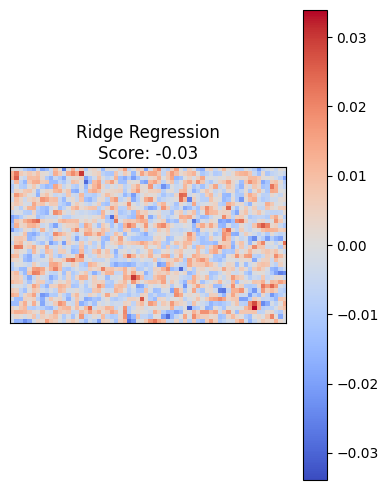

In [181]:
# --- 4. Visualization ---
def plot_receptive_field(rf_data, title):
    """Helper function to plot a receptive field."""
    # Find the min/max to center the colorbar
    vmax = np.max(np.abs(rf_data))
    plt.imshow(rf_data, cmap='coolwarm', vmin=-vmax, vmax=vmax)
    plt.title(title)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])

# Reshape the flat RF vectors back into images
rf_ridge_img = estimated_rf_ridge[1].reshape(36, 64)
plt.figure(figsize=(4, 5))
plt.subplot(1, 1, 1)
plot_receptive_field(rf_ridge_img, f'Ridge Regression\nScore: {ridge_reg.score(X_test_scaled, y_test_scaled):.2f}')
plt.tight_layout()
plt.show()

# Rescale the receptive field images to the original stimulus size and z-score them
rf_ridge_img = estimated_rf_ridge.reshape(estimated_rf_ridge.shape[0], 1, 36, 64)
rf_ridge_img = (rf_ridge_img - np.mean(rf_ridge_img)) / np.std(rf_ridge_img)
rf_ridge_img = torch.from_numpy(rf_ridge_img).float()  # Convert to PyTorch tensor

# # Save the receptive fields to a file
# torch.save({
#     "rf_ridge_img": rf_ridge_img,
#     "config": cfg,
#     "ridge_reg": ridge_reg,
# }, "b6_linear_receptive_fields.pt")
# Save the receptive fields to a file
# torch.save({
#     "meis": rf_ridge_img,  # Reshape to (n_neurons, H, W)
#     "config": cfg,
# }, "b6_linear_receptive_fields_smooth.pt")